In [1]:
import sys
import os

controlnet_dir = os.path.join("/home/pat", 'diffusion_augmentation', 'controlnet')
sys.path.append(controlnet_dir)
# mmcv_dir = os.path.join("/home/pat", 'diffusion_augmentation', 'mmcv')

# sys.path.append(mmcv_dir)

In [2]:
control_net_device = 'cuda:1'

In [3]:
import torch
import numpy as np
import cv2
from PIL import Image
import random
import einops
from torchvision.transforms.functional import to_pil_image
from transformers import pipeline
from controlnet.annotator.util import resize_image, HWC3
from controlnet.annotator.canny import CannyDetector
from controlnet.annotator.uniformer import UniformerDetector
from controlnet.annotator.midas import MidasDetector
from torchvision.transforms.functional import to_pil_image

from controlnet.cldm.model import create_model, load_state_dict
from controlnet.cldm.ddim_hacked import DDIMSampler
from pytorch_lightning import seed_everything



/home/pat/miniconda3/envs/auto_aug/lib/python3.10/site-packages/pytorch_lightning/plugins/training_type/ddp.py:68: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import DistributedOptimizer


In [7]:
def initialize_models():
    # Initialize ControlNet models
    print('Loading ControlNet models...')
    control_net = {}
    model_names = ['control_v11p_sd15_canny', 'control_v11f1p_sd15_depth', 'control_v11p_sd15_seg']
    models = {}
    for name in model_names:
        model = create_model(f'./model_configs/{name}.yaml').cpu()
        model.load_state_dict(load_state_dict('./models/v1-5-pruned.ckpt', location=control_net_device), strict=False)
        model.load_state_dict(load_state_dict(f'./models/{name}.pth', location=control_net_device), strict=False)
        models[name] = model.to(control_net_device)

    # Initialize Control Netdetectors
    apply_canny = CannyDetector()
    apply_depth = MidasDetector()
    apply_seg = UniformerDetector()
    detectors = {'Canny': apply_canny, 'Depth': apply_depth, 'Segmentation': apply_seg}
    
    control_net['models'] = models
    control_net['detectors'] = detectors
    return control_net

In [5]:
def control_augment(control_net, device, det, input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    with torch.no_grad():
        input_image = np.array(input_image)
        input_image = HWC3(input_image)
        input_image = resize_image(input_image, detect_resolution)
        H, W, C = input_image.shape

        if det == 'Canny':
            detected_map = control_net['detectors']['Canny'](input_image, low_threshold, high_threshold)
            model = control_net['models']['control_v11p_sd15_canny']
        elif det == 'Depth':
            # print(control_net['detectors']['Depth'](input_image))
            detected_map = control_net['detectors']['Depth'](input_image)
            model = control_net['models']['control_v11f1p_sd15_depth']
        elif det == 'Segmentation':
            detected_map = control_net['detectors']['Segmentation'](input_image)
            model = control_net['models']['control_v11p_sd15_seg']
        else:
            raise ValueError(f"Unknown detection type: {det}")

        detected_map = HWC3(detected_map)
        detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)

        img = resize_image(input_image, image_resolution)
        H, W, C = img.shape

        control = torch.from_numpy(detected_map.copy()).float().to(device) / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)

        ddim_sampler = DDIMSampler(model)
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return detected_map, results[0]


In [8]:
control_net = initialize_models()

Loading ControlNet models...


/home/pat/miniconda3/envs/auto_aug/lib/python3.10/site-packages/pytorch_lightning/core/lightning.py:2058: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

/home/pat/miniconda3/envs/auto_aug/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'logit_scale', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

/home/pat/diffusion_augmentation/controlnet/cldm/model.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = get_state_dict(torch.load(ckpt_path, map_location=to

Loaded state_dict from [./models/v1-5-pruned.ckpt]
Loaded state_dict from [./models/control_v11p_sd15_canny.pth]
ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'logit_scale', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.layer_norm1.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.17.self

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'logit_scale', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.layer_norm1.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.17.self

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

/home/pat/diffusion_augmentation/controlnet/annotator/midas/midas/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location=

Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /home/pat/diffusion_augmentation/controlnet/annotator/ckpts/upernet_global_small.pth


/home/pat/diffusion_augmentation/controlnet/annotator/uniformer/mmcv/runner/checkpoint.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename

In [9]:
control_net

{'models': {'control_v11p_sd15_canny': ControlLDM(
    (model): DiffusionWrapper(
      (diffusion_model): ControlledUnetModel(
        (time_embed): Sequential(
          (0): Linear(in_features=320, out_features=1280, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (input_blocks): ModuleList(
          (0): TimestepEmbedSequential(
            (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1-2): 2 x TimestepEmbedSequential(
            (0): ResBlock(
              (in_layers): Sequential(
                (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
                (1): SiLU()
                (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
              (h_upd): Identity()
              (x_upd): Identity()
              (emb_layers): Sequential(
                (0): SiLU()
                (1): Linear(in_features=1280, out

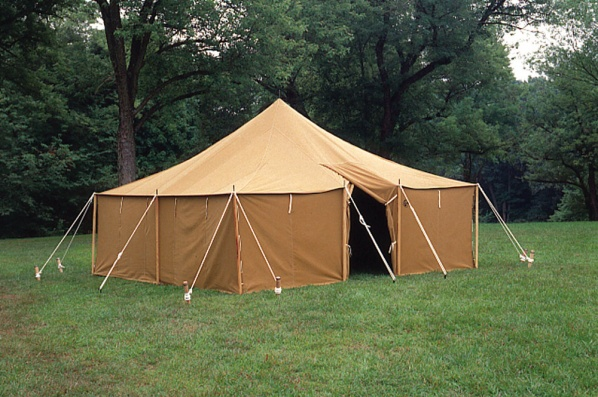

Caption: a tent in the middle of a field


In [11]:
image_path = '/home/pat/diffusion_augmentation/test_images/original.png'
image = Image.open(image_path)

display(image)
caption = "a tent in the middle of a field"
print(f"Caption: {caption}")

In [12]:
augmented_images = {}
preprocessed_images = {}
pil_image = image
for det_type in ['Canny', 'Depth', 'Segmentation']:
    print(f"Processing {det_type}...")
    preprocessed, augmented = control_augment(
        control_net=control_net,
        device=control_net_device,
        det=det_type,
        input_image=pil_image,
        prompt=caption,
        a_prompt="clear image, photorealistic",
        n_prompt="multiple, mushed, low quality, cropped, worst quality",
        num_samples=1,
        image_resolution=512,
        detect_resolution=512,
        ddim_steps=20,
        guess_mode=False,
        strength=1.0,
        scale=7.5,
        seed=-1,
        eta=0.0,
        low_threshold=100,
        high_threshold=200,
        
    )
    augmented_images[det_type] = Image.fromarray(augmented)
    preprocessed_images[det_type] = Image.fromarray(preprocessed)


Global seed set to 58588


Processing Canny...
Data shape for DDIM sampling is (1, 4, 64, 96), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

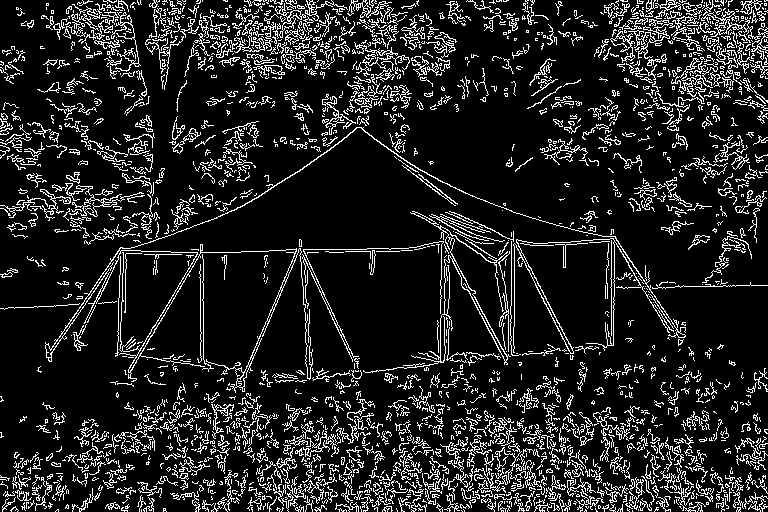

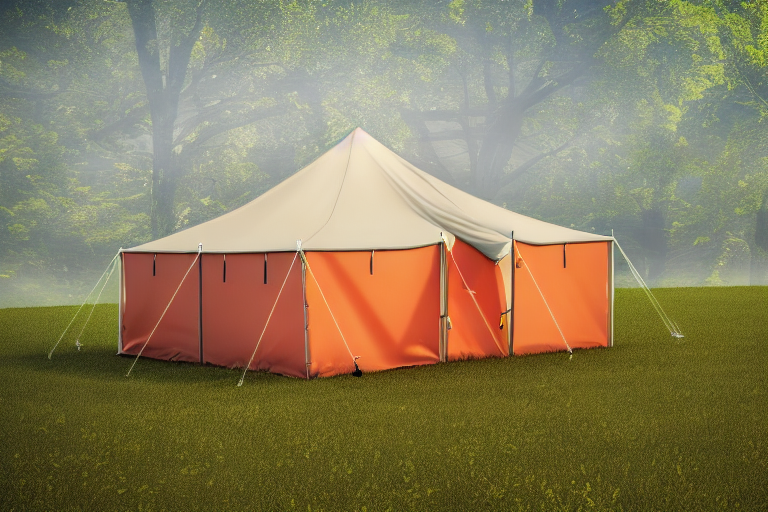

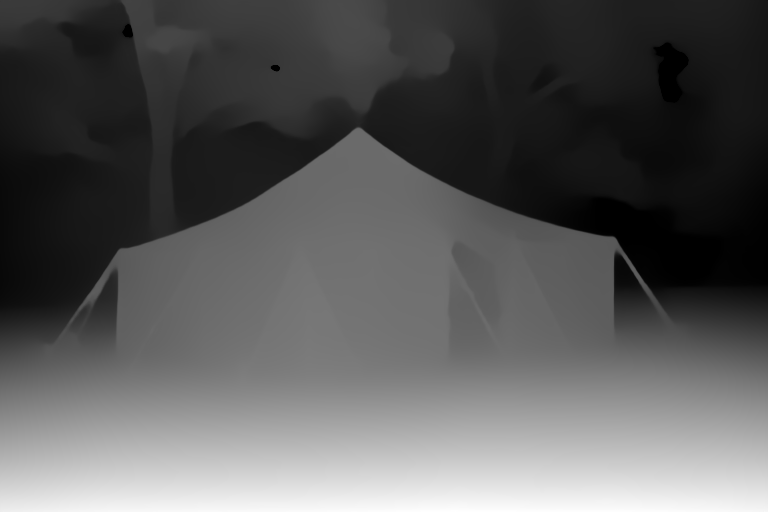

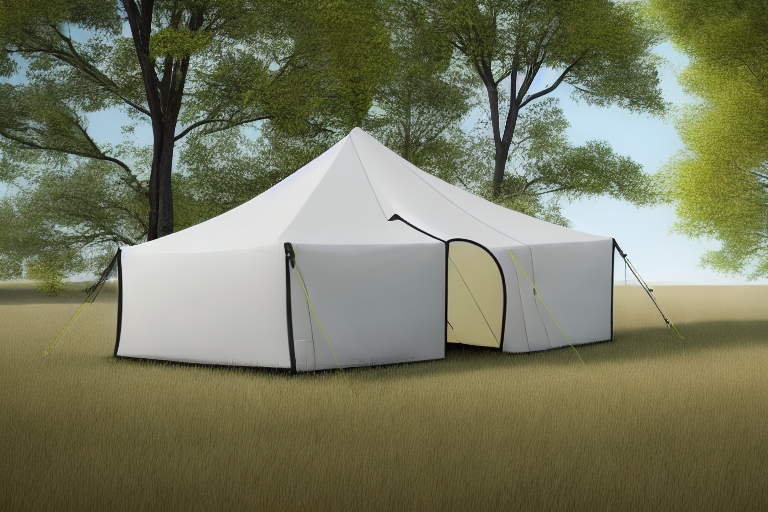

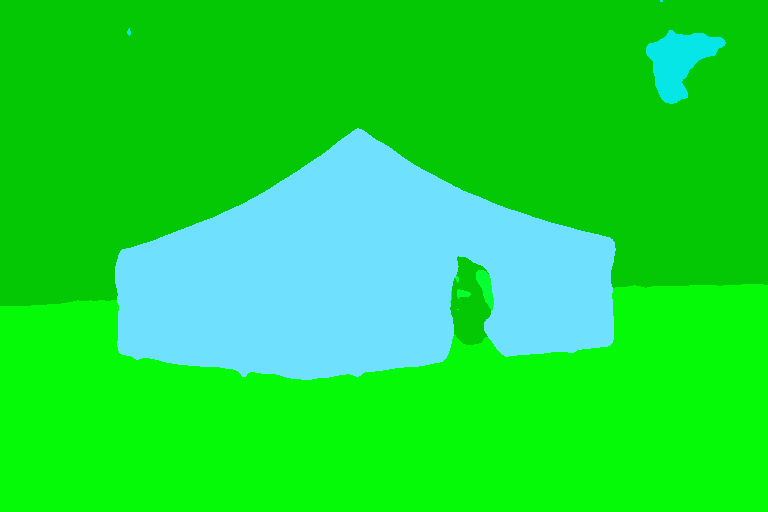

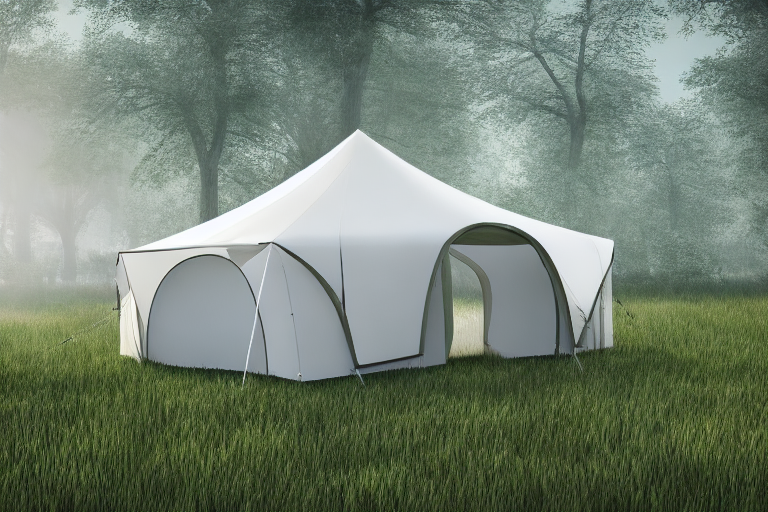

In [12]:
# display all the images
display(preprocessed_images['Canny'])
display(augmented_images['Canny'])
display(preprocessed_images['Depth'])
display(augmented_images['Depth'])
display(preprocessed_images['Segmentation'])
display(augmented_images['Segmentation'])